# 05 - Vertex AI > Notebooks - Models Built in Notebooks with Tensorflow

>**NOTE:** The notebooks in the `05 - TensorFlow` series demonstrate training, serving and operations for TensorFlow models and take advantage of [Vertex AI TensorBoard](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview) to track training across experiments.  Running these notebooks will create a Vertex AI TensorBoard instance which has a user-based montly pricing that is different than other services that charge by usage.  This cost is $300 per user - [Vertex AI Pricing](https://cloud.google.com/vertex-ai/pricing#tensorboard).

Where a model gets trained is where it consumes computing resources.  With Vertex AI, you have choices for configuring the computing resources available at training.  This notebook is an example of an execution environment.  When it was set up there were choices for machine type and accelerators (GPUs).  

This notebook shows training a model directly within the runtime of the notebook environment.  Then the model is saved and moved to GCS for deployment to a Vertex AI > Endpoint for online predictions.  The model training is done with [Tensorflow](https://www.tensorflow.org/), specifically [Keras](https://keras.io/), and was designed to show a neural network approach to logistic regression.  The training data batches are read from BigQuery using [Tensorflow I/O](https://www.tensorflow.org/io).

The other notebooks in this series (`05a-05i`) show how to move the training into a managed compute environment using Vertex AI > Training.  The first step to being able to use a training job is converting the code in this notebook into a training script.  This processs is covered in:
- [05 - Vertex AI Custom Model - TensorFlow - Notebook to Script.ipynb](./05%20-%20Vertex%20AI%20Custom%20Model%20-%20TensorFlow%20-%20Notebook%20to%20Script.ipynb)
- [05 - Vertex AI Custom Model - TensorFlow - Notebook to Hyperparameter Tuning Script.ipynb](./05%20-%20Vertex%20AI%20Custom%20Model%20-%20TensorFlow%20-%20Notebook%20to%20Hyperparameter%20Tuning%20Script.ipynb)

**Video Walkthrough of this notebook:**

Includes conversational walkthrough and more explanatory information than the notebook:

<p align="center" width="100%"><center><a href="https://youtu.be/-5E3hWfsB4I" target="_blank" rel="noopener noreferrer"><img src="../architectures/thumbnails/playbutton/05.png" width="40%"></a></center></p>

**Prerequisites:**
- [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)

**Resources:**
-  [BigQuery Tensorflow Reader](https://www.tensorflow.org/io/tutorials/bigquery)
-  [Keras Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)
   -  [Keras API](https://www.tensorflow.org/api_docs/python/tf/keras)
-  [Python Client For Google BigQuery](https://googleapis.dev/python/bigquery/latest/index.html)
-  [Tensorflow Python Client](https://www.tensorflow.org/api_docs/python/tf)
-  [Tensorflow I/O Python Client](https://www.tensorflow.org/io/api_docs/python/tfio/bigquery)
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
- Pre-built Containers for Vertex AI
    - [Training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers)
    - [Prediction & Explaination](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/05_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/05_console.png" width="45%">
</p>

---
## Setup

inputs:

In [97]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [98]:
REGION = 'us-central1'
EXPERIMENT = '05'
SERIES = '05'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'
DEPLOY_IMAGE='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-7:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters
EPOCHS = 4
BATCH_SIZE = 100

packages:

In [99]:
from google.cloud import bigquery

from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
import tensorflow as tf

from google.cloud import aiplatform
from datetime import datetime
import os

from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np
import pandas as pd

clients:

In [100]:
aiplatform.init(project = PROJECT_ID, location = REGION)
bq = bigquery.Client()

parameters:

In [101]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
DIR = f"temp/{EXPERIMENT}"

environment:

In [102]:
!rm -rf {DIR}
!mkdir -p {DIR}

Experiment Tracking:

In [103]:
FRAMEWORK = 'tf'
TASK = 'classification'
MODEL_TYPE = 'dnn'
EXPERIMENT_NAME = f'experiment-{SERIES}-{EXPERIMENT}-{FRAMEWORK}-{TASK}-{MODEL_TYPE}'
RUN_NAME = f'run-{TIMESTAMP}'

---
## Get Vertex AI Experiments Tensorboard Instance Name
[Vertex AI Experiments](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview) has managed [Tensorboard](https://www.tensorflow.org/tensorboard) instances that you can track Tensorboard Experiments (a training run or hyperparameter tuning sweep).  

The training job will show up as an experiment for the Tensorboard instance and have the same name as the training job ID.

This code checks to see if a Tensorboard Instance has been created in the project, retrieves it if so, creates it otherwise:

In [104]:
tb = aiplatform.Tensorboard.list(filter=f"labels.series={SERIES}")
if tb:
    tb = tb[0]
else: 
    tb = aiplatform.Tensorboard.create(display_name = SERIES, labels = {'series' : f'{SERIES}'})

In [105]:
tb.resource_name

'projects/1026793852137/locations/us-central1/tensorboards/7179142426307592192'

---
## Setup Vertex AI Experiments

The code in this section initializes the experiment and starts a run that represents this notebook.  Throughout the notebook sections for model training and evaluation information will be logged to the experiment using:
- [.log_params](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_params)
- [.log_metrics](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_metrics)
- [.log_time_series_metrics](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_log_time_series_metrics)

Initialize the Experiment:

In [106]:
aiplatform.init(experiment = EXPERIMENT_NAME, experiment_tensorboard = tb.resource_name)

Create an experiment run:

In [107]:
expRun = aiplatform.ExperimentRun.create(run_name = RUN_NAME, experiment = EXPERIMENT_NAME)

Associating projects/1026793852137/locations/us-central1/metadataStores/default/contexts/experiment-05-05-tf-classification-dnn-run-20220927184222 to Experiment: experiment-05-05-tf-classification-dnn


Log parameters to the experiment run:

In [108]:
expRun.log_params({'experiment': EXPERIMENT, 'series': SERIES, 'project_id': PROJECT_ID})

---
## Training Data
In this exercise the data source is a table in Google BigQuery.  While it is possible to bring the entire table into the local notebook as a Pandas dataframe, it is not a scalable solution for very large training tables.  In this section the connection to BigQuery is done using Tensorflow I/O to read batches of training data in parallel during model training.

### Data Schema
Using BigQueries Information_Schema is an easy way to quickly retrieve the column information about our training data.  In this case we need the column names and data types to setup the data reading and the model inputs.  This section retrieves the column information for the training table source.

In [109]:
query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{BQ_TABLE}'"
schema = bq.query(query).to_dataframe()
schema

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position,collation_name,column_default
0,statmike-mlops-349915,fraud,fraud_prepped,Time,1,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
1,statmike-mlops-349915,fraud,fraud_prepped,V1,2,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
2,statmike-mlops-349915,fraud,fraud_prepped,V2,3,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
3,statmike-mlops-349915,fraud,fraud_prepped,V3,4,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
4,statmike-mlops-349915,fraud,fraud_prepped,V4,5,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
5,statmike-mlops-349915,fraud,fraud_prepped,V5,6,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
6,statmike-mlops-349915,fraud,fraud_prepped,V6,7,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
7,statmike-mlops-349915,fraud,fraud_prepped,V7,8,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
8,statmike-mlops-349915,fraud,fraud_prepped,V8,9,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL
9,statmike-mlops-349915,fraud,fraud_prepped,V9,10,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN,NULL,NULL


### Number of Classes for the Label Column: VAR_TARGET
This is a supervised learning example that classifies examples into the classes found in the label column stored in the variable `VAR_TARGET`.

In [110]:
nclasses = bq.query(query = f'SELECT DISTINCT {VAR_TARGET} FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE} WHERE {VAR_TARGET} is not null').to_dataframe()
nclasses

,Class
0,0
1,1


In [111]:
nclasses = nclasses.shape[0]
nclasses

2

In [112]:
expRun.log_params({'data_source': f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}', 'nclasses': nclasses, 'var_split': 'splits', 'var_target': VAR_TARGET})

### Selected Columns and Data Types

Use the the table schema to prepare the TensorFlow model inputs:
- Omit unused columns
- Create list of `selected_fields` from the training source
- Define the data types, `output_types`, using the schema data and remapping to desired precision if needed

In [113]:
# Make a list of columns to omit
OMIT = VAR_OMIT.split() + ['splits']

# use schema to prepare a list of columns to read from BigQuery
selected_fields = schema[~schema.column_name.isin(OMIT)].column_name.tolist()

# all the columns in this data source are either float64 or int64
output_types = [dtypes.float64 if x=='FLOAT64' else dtypes.int64 for x in schema[~schema.column_name.isin(OMIT)].data_type.tolist()]

---
## Read From BigQuery Using TensorFlow I/O 

### Divide the inputs into features and target

Define a function that remaps the input data for TensorFlow into:
- features
- `target` - one_hot encoded for multi-class classification and also works for binary classification

In [114]:
def transTable(row_dict):
    target = row_dict.pop(VAR_TARGET)
    target = tf.one_hot(tf.cast(target,tf.int64), nclasses)
    target = tf.cast(target, tf.float32)
    return(row_dict, target)

### Setup Tensorflow I/O to Read Batches from BigQuery

Setup TensorFlow_IO client > session > table + table.map
- https://www.tensorflow.org/io/api_docs/python/tfio/bigquery/BigQueryClient

In [115]:
def bq_reader(split):
    reader = BigQueryClient()

    training = reader.read_session(
        parent = f"projects/{PROJECT_ID}",
        project_id = BQ_PROJECT,
        table_id = BQ_TABLE,
        dataset_id = BQ_DATASET,
        selected_fields = selected_fields,
        output_types = output_types,
        row_restriction = f"splits='{split}'",
        requested_streams = 3
    )
    
    return training

In [116]:
train = bq_reader('TRAIN').parallel_read_rows().prefetch(1).map(transTable).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE)
validate = bq_reader('VALIDATE').parallel_read_rows().prefetch(1).map(transTable).batch(BATCH_SIZE)
test = bq_reader('TEST').parallel_read_rows().prefetch(1).map(transTable).batch(BATCH_SIZE)

In [117]:
expRun.log_params({'training.batch_size': BATCH_SIZE, 'training.shuffle': 10*BATCH_SIZE, 'training.prefetch': 1})

Review a single batch of the train data:

In [118]:
for features, target in train.take(1):
    print('features:\n',list(features.keys()))
    print('\ntarget:\n',target[0:10])

features:
 ['Amount', 'Time', 'V1', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V2', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']

target:
 tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


---
## Define the Model: In The Notebook (local runtime)

Define the Model:
- Building the model using the [Keras functional api](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
- This is basically multi-class logistic regression where the feature space is mapped to the number of classes in the target by a [softmax activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax)
- The [keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) is made up of `inputs` and `outputs`
    - the inputs are a list of [keras.Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) tensors that was constructed above
    - the outputs are a group of [keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers)
        - connects each input to a [Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) with units set to the number of features
        - connecting to a [BatchNormalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)
            - for each batch of inputs it scales each feature to have mean = 0 and standard deviation = 1 for the batch
            - Note on Normalization - If you are using TensorFlow 2.6 or higher then you can also try a normalization layer with the [adapt method](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization#adapt) as a preprocessing layer (does not update during training).
        - ending with a [Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) with units set to the number of class levels in the target

Adding metrics to the model:
- Specifying 'accuracy' triggers conversion to [tf.keras.metrics.CategoricalAccuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/CategoricalAccuracy) due to the loss function being [tf.keras.losses.CategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)
- If the target variable is highly imbalanced then it is good to consider the area under the precision-recall curve.  This is requested with [tf.keras.metrics.AUC(curve='PR')](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC)

In [119]:
# Logistic Regression with hidden layers

# model input definitions
feature_columns = {header: tf.feature_column.numeric_column(header) for header in selected_fields if header != VAR_TARGET}
feature_layer_inputs = {header: tf.keras.layers.Input(shape = (1,), name = header) for header in selected_fields if header != VAR_TARGET}

# feature columns to a Dense Feature Layer
feature_layer_outputs = tf.keras.layers.DenseFeatures(feature_columns.values(), name = 'feature_layer')(feature_layer_inputs)

# batch normalization then Dense with softmax activation to nclasses
layers = tf.keras.layers.BatchNormalization(name = 'batch_normalization_layer')(feature_layer_outputs)
layers = tf.keras.layers.Dense(64, activation = 'relu', name = 'hidden_layer')(layers)
layers = tf.keras.layers.Dense(32, activation = 'relu', name = 'embedding_layer')(layers)
layers = tf.keras.layers.Dense(nclasses, activation = tf.nn.softmax, name = 'prediction_layer')(layers)

# the model
model = tf.keras.Model(
    inputs = feature_layer_inputs,
    outputs = layers,
    name = EXPERIMENT
)
opt = tf.keras.optimizers.SGD() #SGD or Adam
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(
    optimizer = opt,
    loss = loss,
    metrics = ['accuracy', tf.keras.metrics.AUC(curve = 'PR', name = 'auprc')]
)

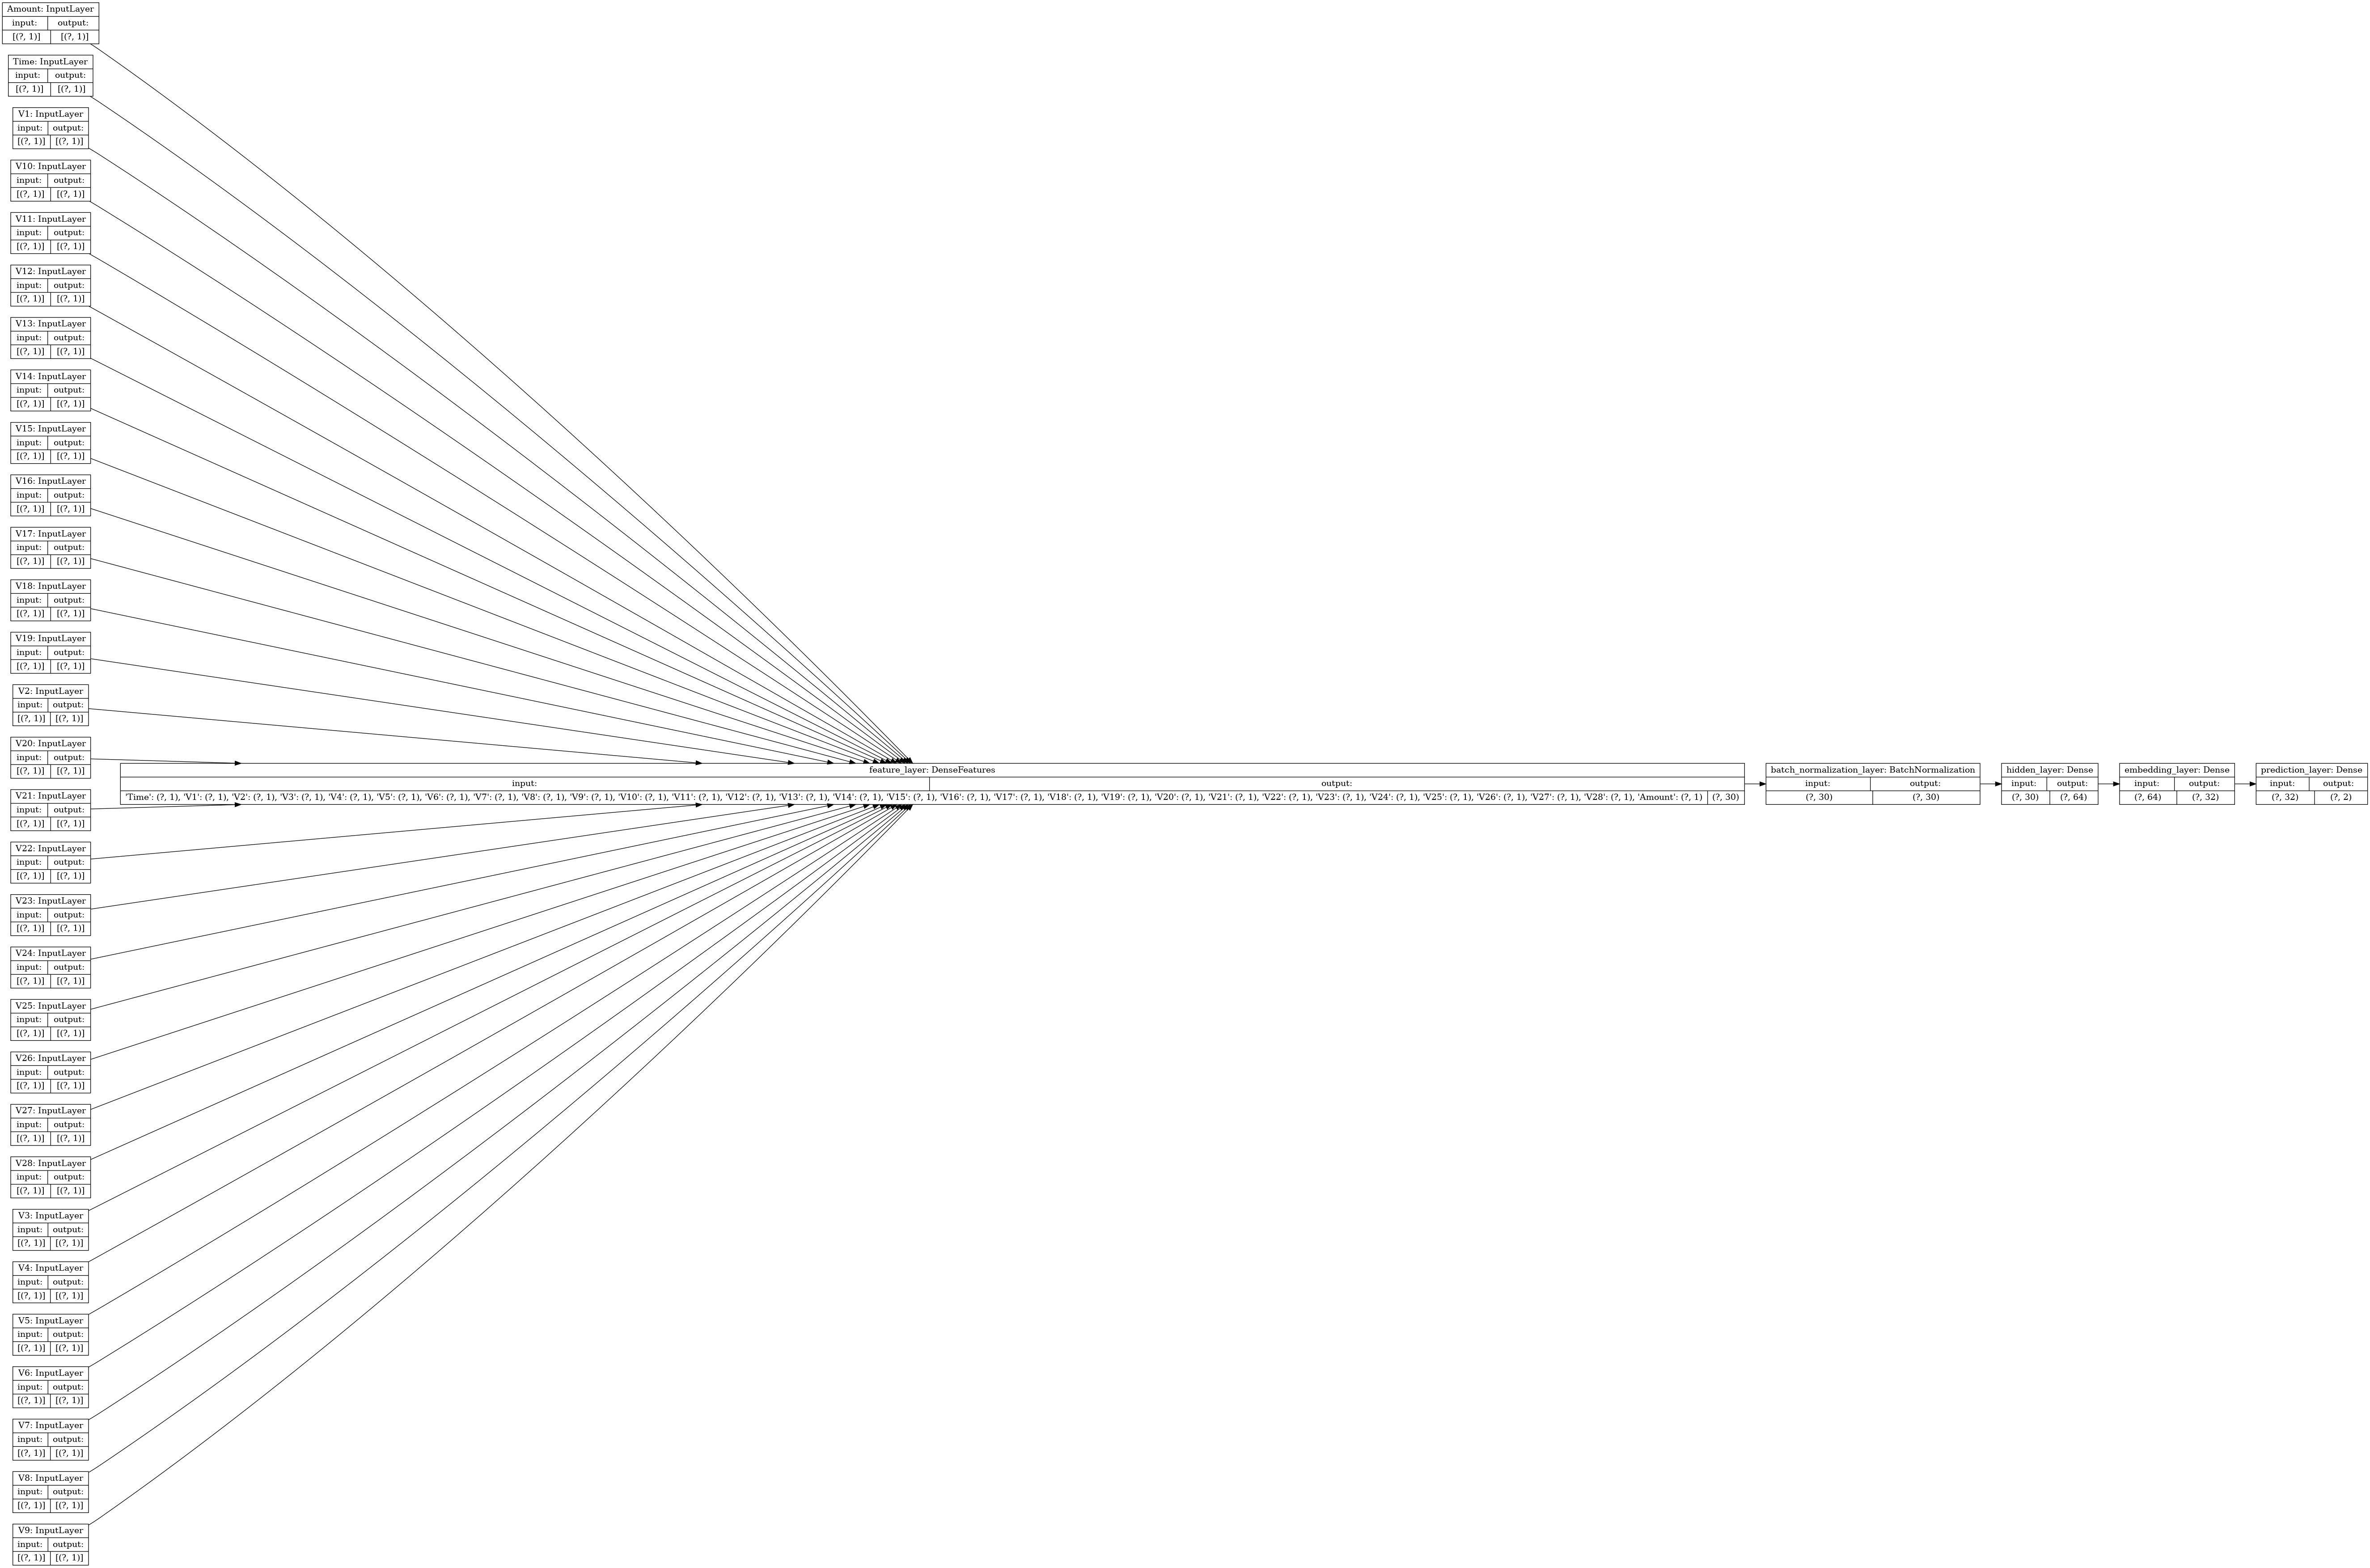

In [120]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [121]:
model.summary()

Model: "05"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Amount (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Time (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
V1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
V10 (InputLayer)                [(None, 1)]          0                                            
_________________________________________________________________________________________________

---
## Train The Model: In The Notebook (local runtime)

Fit the Model:

In [122]:
# setup tensorboard logs and train
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = os.path.join(DIR, "logs", f'{TIMESTAMP}'), histogram_freq=1)
history = model.fit(train, epochs = EPOCHS, callbacks = [tensorboard_callback], validation_data = validate)

2022-09-27 18:42:51.657275: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


Epoch 1/4
      1/Unknown - 0s 254us/step - loss: 0.8188 - accuracy: 0.3100 - auprc: 0.3842

2022-09-27 18:42:54.705761: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


      2/Unknown - 0s 170ms/step - loss: 0.7698 - accuracy: 0.3950 - auprc: 0.4371WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0396s vs `on_train_batch_end` time: 0.2990s). Check your callbacks.
      7/Unknown - 1s 73ms/step - loss: 0.6847 - accuracy: 0.5914 - auprc: 0.6047

2022-09-27 18:42:55.025256: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: temp/05/logs/20220927184222/train/plugins/profile/2022_09_27_18_42_55
2022-09-27 18:42:55.030653: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to temp/05/logs/20220927184222/train/plugins/profile/2022_09_27_18_42_55/vertex-ai-mlops.trace.json.gz
2022-09-27 18:42:55.038951: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: temp/05/logs/20220927184222/train/plugins/profile/2022_09_27_18_42_55
2022-09-27 18:42:55.039421: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to temp/05/logs/20220927184222/train/plugins/profile/2022_09_27_18_42_55/vertex-ai-mlops.memory_profile.json.gz
2022-09-27 18:42:55.039935: I tensorflow/python/profiler/internal/profiler_wrapper.cc:111] Creating directory: temp/05/logs/20220927184222/train/plugins/profile/2

2281/2281 [==============================] - 66s 29ms/step - loss: 0.0247 - accuracy: 0.9967 - auprc: 0.9985 - val_loss: 0.0091 - val_accuracy: 0.9987 - val_auprc: 0.9993
Epoch 2/4
2281/2281 [==============================] - 67s 29ms/step - loss: 0.0060 - accuracy: 0.9990 - auprc: 0.9995 - val_loss: 0.0074 - val_accuracy: 0.9991 - val_auprc: 0.9994
Epoch 3/4
2281/2281 [==============================] - 65s 28ms/step - loss: 0.0047 - accuracy: 0.9992 - auprc: 0.9995 - val_loss: 0.0068 - val_accuracy: 0.9992 - val_auprc: 0.9994
Epoch 4/4
2281/2281 [==============================] - 67s 29ms/step - loss: 0.0044 - accuracy: 0.9993 - auprc: 0.9995 - val_loss: 0.0065 - val_accuracy: 0.9993 - val_auprc: 0.9994


In [123]:
history.history['loss'][-1]

0.00439281202852726

In [124]:
expRun.log_params({'training.epochs': history.params['epochs']})
history.params

{'verbose': 1, 'epochs': 4, 'steps': None}

Log the time series metrics to the experiments TensorBoard:

In [125]:
for e in range(0, history.params['epochs']):
    expRun.log_time_series_metrics(
        {
            'train_loss': history.history['loss'][e],
            'train_accuracy': history.history['accuracy'][e],
            'train_auprc': history.history['auprc'][e],
            'val_loss': history.history['val_loss'][e],
            'val_accuracy': history.history['val_accuracy'][e],
            'val_auprc': history.history['val_auprc'][e]
        }
    )

---
## Evaluate The Model: In The Notebook (local runtime)

Evaluate the model with the test data:

In [126]:
loss, accuracy, auprc = model.evaluate(test)

286/286 [==============================] - 5s 16ms/step - loss: 0.0046 - accuracy: 0.9994 - auprc: 0.9994


In [127]:
expRun.log_metrics({'test_loss': loss, 'test_accuracy': accuracy, 'test_auprc': auprc})

In [128]:
loss, accuracy, auprc = model.evaluate(validate)

283/283 [==============================] - 6s 21ms/step - loss: 0.0065 - accuracy: 0.9993 - auprc: 0.9994


In [129]:
expRun.log_metrics({'val_loss': loss, 'val_accuracy': accuracy, 'val_auprc': auprc})

In [130]:
loss, accuracy, auprc = model.evaluate(train)

2281/2281 [==============================] - 52s 23ms/step - loss: 0.0048 - accuracy: 0.9993 - auprc: 0.9994


In [131]:
expRun.log_metrics({'train_loss': loss, 'train_accuracy': accuracy, 'train_auprc': auprc})

---
## Evaluate The Training With Tensorboard (Local to Notebook)

Visual ML

Resource: https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks

In [132]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [133]:
%tensorboard --logdir $DIR/logs

Reusing TensorBoard on port 6006 (pid 32492), started 7:44:20 ago. (Use '!kill 32492' to kill it.)

---
## Save The Model

Create Prediction from a batch of the test data and review first row:

In [134]:
model.predict(test.take(1))[0]

array([9.9997985e-01, 2.0149959e-05], dtype=float32)

Save The Model

In [135]:
model.save(f'{URI}/models/{TIMESTAMP}/model')

INFO:tensorflow:Assets written to: gs://statmike-mlops-349915/05/05/models/20220927184222/model/assets


In [136]:
expRun.log_params({'model.save': f'{URI}/models/{TIMESTAMP}/model'})

### Review The Saved Model

#### Keras Model Load

In [137]:
keras_model = tf.keras.models.load_model(f'{URI}/models/{TIMESTAMP}/model')

In [138]:
keras_model.name

'05'

In [139]:
keras_model.inputs

[<tf.Tensor 'Amount_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'Time_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V1_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V10_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V11_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V12_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V13_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V14_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V15_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V16_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V17_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V18_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V19_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V2_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V20_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V21_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V22_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V23_3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'V24_3:0' shap

In [140]:
keras_model.output.name

'prediction_layer/Softmax_3:0'

In [141]:
keras_model.summary()

Model: "05"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Amount (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Time (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
V1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
V10 (InputLayer)                [(None, 1)]          0                                            
_________________________________________________________________________________________________

#### TensorFlow Model Load

In [142]:
tf_model = tf.saved_model.load(f'{URI}/models/{TIMESTAMP}/model')

In [143]:
tf_model.signatures

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(Amount, Time, V1, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V2, V20, V21, V22, V23, V24, V25, V26, V27, V28, V3, V4, V5, V6, V7, V8, V9) at 0x7F4674CFC5D0>})

In [144]:
tf_model.signatures['serving_default']

<ConcreteFunction signature_wrapper(Amount, Time, V1, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V2, V20, V21, V22, V23, V24, V25, V26, V27, V28, V3, V4, V5, V6, V7, V8, V9) at 0x7F4674CFC5D0>

In [145]:
tf_model.signatures['serving_default'].structured_input_signature[1].keys()

dict_keys(['V7', 'V12', 'V17', 'V4', 'V5', 'V2', 'V19', 'V13', 'V28', 'V25', 'V8', 'V3', 'V9', 'V22', 'Amount', 'V23', 'V1', 'V24', 'V6', 'V20', 'V11', 'V27', 'Time', 'V10', 'V15', 'V26', 'V18', 'V21', 'V16', 'V14'])

In [146]:
tf_model.signatures['serving_default'].structured_outputs

{'prediction_layer': TensorSpec(shape=(None, 2), dtype=tf.float32, name='prediction_layer')}

---
## Serving

### Upload The Model

In [147]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        model = aiplatform.Model.upload(
            display_name = f'{SERIES}_{EXPERIMENT}',
            model_id = f'model_{SERIES}_{EXPERIMENT}',
            parent_model =  modelmatch[0].resource_name,
            serving_container_image_uri = DEPLOY_IMAGE,
            artifact_uri = f"{URI}/models/{TIMESTAMP}/model",
            is_default_version = True,
            version_aliases = [RUN_NAME],
            version_description = RUN_NAME,
            labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'experiment_name' : f'{EXPERIMENT_NAME}', 'run_name' : f'{RUN_NAME}'}        
        )
else:
    print('This is a new model, creating in model registry')
    model = aiplatform.Model.upload(
        display_name = f'{SERIES}_{EXPERIMENT}',
        model_id = f'model_{SERIES}_{EXPERIMENT}',
        serving_container_image_uri = DEPLOY_IMAGE,
        artifact_uri = f"{URI}/models/{TIMESTAMP}/model",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'experiment_name' : f'{EXPERIMENT_NAME}', 'run_name' : f'{RUN_NAME}'}
    )
    
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{model.name}?project={PROJECT_ID}')

Model Already in Registry:
Loading model as new default version.
Creating Model
Create Model backing LRO: projects/1026793852137/locations/us-central1/models/model_05_05/operations/7437090396804481024
Model created. Resource name: projects/1026793852137/locations/us-central1/models/2857424012403802112@3
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/2857424012403802112@3')
Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/2857424012403802112?project=statmike-mlops-349915


>**Note** on Version Aliases:
>Expectation is a name starting with `a-z` that can include `[a-zA-Z0-9-]`
>
>**Retrieve a Model Resource**
>[aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)
>```Python
model = aiplatform.Model(model_name = f'model_{SERIES}_{EXPERIMENT}') # retrieves default version
model = aiplatform.Model(model_name = f'model_{SERIES}_{EXPERIMENT}@time-{TIMESTAMP}') # retrieves specific version
model = aiplatform.Model(model_name = f'model_{SERIES}_{EXPERIMENT}', version = f'time-{TIMESTAMP}') # retrieves specific version
```

### Vertex AI Experiment Update and Review

In [148]:
expRun.log_params({
    'model.uri': model.uri,
    'model.display_name': model.display_name,
    'model.name': model.name,
    'model.resource_name': model.resource_name,
    'model.version_id': model.version_id,
    'model.versioned_resource_name': model.versioned_resource_name
})

Complete the experiment run:

In [149]:
expRun.update_state(state = aiplatform.gapic.Execution.State.COMPLETE)

Retrieve the experiment:

In [150]:
exp = aiplatform.Experiment(experiment_name = EXPERIMENT_NAME)

In [151]:
exp.get_data_frame()

,experiment_name,run_name,run_type,state,param.training.shuffle,param.nclasses,param.model.name,param.model.display_name,param.training.prefetch,param.training.batch_size,...,metric.val_loss,metric.test_auprc,metric.train_accuracy,metric.train_auprc,time_series_metric.val_loss,time_series_metric.val_accuracy,time_series_metric.val_auprc,time_series_metric.train_loss,time_series_metric.train_auprc,time_series_metric.train_accuracy
0,experiment-05-05-tf-classification-dnn,run-20220927184222,system.ExperimentRun,COMPLETE,1000.0,2.0,2857424012403802112,05_05,1.0,100.0,...,0.006504,0.999397,0.999329,0.999413,0.006504,0.999256,0.999390,0.004393,0.999549,0.999259
1,experiment-05-05-tf-classification-dnn,run-20220927110007,system.ExperimentRun,COMPLETE,1000.0,2.0,2857424012403802112,05_05,1.0,100.0,...,0.006514,0.999445,0.999417,0.999480,0.006514,0.999256,0.999394,0.004197,0.999583,0.999360
2,experiment-05-05-tf-classification-dnn,run-20220926162349,system.ExperimentRun,COMPLETE,1000.0,2.0,model_05_05,05_05,1.0,100.0,...,0.006727,0.999533,0.999364,0.999406,0.006727,0.999256,0.999342,0.004380,0.999572,0.999334
3,experiment-05-05-tf-classification-dnn,run-20220827023100,system.ExperimentRun,COMPLETE,1000.0,2.0,NaN,05_fraud,1.0,100.0,...,0.005987,0.999394,0.999290,0.999434,0.005987,0.999221,0.999388,0.004572,0.999561,0.999198
4,experiment-05-05-tf-classification-dnn,run-20220825175329,system.ExperimentRun,COMPLETE,1000.0,2.0,NaN,05_fraud,1.0,100.0,...,0.007228,0.999344,0.999373,0.999357,0.007228,0.999221,0.999338,0.004605,0.999555,0.999298
5,experiment-05-05-tf-classification-dnn,run-20220825161109,system.ExperimentRun,COMPLETE,1000.0,2.0,NaN,05_fraud,1.0,100.0,...,0.005937,0.999397,0.999320,0.999419,0.005937,0.999221,0.999391,0.004450,0.999555,0.999246
6,experiment-05-05-tf-classification-dnn,run-20220825143943,system.ExperimentRun,COMPLETE,1000.0,2.0,NaN,05_fraud,1.0,100.0,...,0.006775,0.999398,0.999272,0.999427,0.006775,0.999221,0.999392,0.004656,0.999533,0.999237


Review the Experiments TensorBoard to compare runs:

In [152]:
print(f"The Experiment TensorBoard Link:\nhttps://{REGION}.tensorboard.googleusercontent.com/experiment/{tb.resource_name.replace('/', '+')}+experiments+{exp.name}")

The Experiment TensorBoard Link:
https://us-central1.tensorboard.googleusercontent.com/experiment/projects+1026793852137+locations+us-central1+tensorboards+7179142426307592192+experiments+experiment-05-05-tf-classification-dnn


In [153]:
expRun.get_time_series_data_frame()

,step,wall_time,val_loss,val_accuracy,val_auprc,train_loss,train_auprc,train_accuracy
0,1,2022-09-27 18:48:37.908000+00:00,0.009092,0.998690,0.999277,0.024706,0.998502,0.996720
1,2,2022-09-27 18:48:39.267000+00:00,0.007375,0.999115,0.999382,0.005951,0.999461,0.999022
2,3,2022-09-27 18:48:40.595000+00:00,0.006843,0.999221,0.999388,0.004731,0.999533,0.999220
3,4,2022-09-27 18:48:42.599000+00:00,0.006504,0.999256,0.999390,0.004393,0.999549,0.999259


### Compare This Run Using Experiments

Get a list of all experiments in this project:

In [154]:
experiments = aiplatform.Experiment.list()

Remove experiments not in the SERIES:

In [155]:
experiments = [e for e in experiments if e.name.split('-')[0:2] == ['experiment', SERIES]]

Combine the runs from all experiments in SERIES into a single dataframe:

In [156]:
results = []
for experiment in experiments:
        results.append(experiment.get_data_frame())
        print(experiment.name)
results = pd.concat(results)

experiment-05-05i-tf-classification-dnn
experiment-05-05h-tf-classification-dnn
experiment-05-05g-tf-classification-dnn
experiment-05-05f-tf-classification-dnn
experiment-05-05e-tf-classification-dnn
experiment-05-05d-tf-classification-dnn
experiment-05-05c-tf-classification-dnn
experiment-05-05b-tf-classification-dnn
experiment-05-05a-tf-classification-dnn
experiment-05-05-tf-classification-dnn


Create ranks for models within experiment and across the entire SERIES:

In [157]:
def ranker(metric = 'metric.test_auprc'):
    ranks = results[['experiment_name', 'run_name', 'param.model.display_name', 'param.model.version_id', metric]].copy().reset_index(drop = True)
    ranks['series_rank'] = ranks[metric].rank(method = 'dense', ascending = False)
    ranks['experiment_rank'] = ranks.groupby('experiment_name')[metric].rank(method = 'dense', ascending = False)
    return ranks.sort_values(by = ['experiment_name', 'run_name'])
    
ranks = ranker('metric.test_auprc')
ranks

,experiment_name,run_name,param.model.display_name,param.model.version_id,metric.test_auprc,series_rank,experiment_rank
123,experiment-05-05-tf-classification-dnn,run-20220825143943,05_fraud,1,0.999398,89.0,3.0
122,experiment-05-05-tf-classification-dnn,run-20220825161109,05_fraud,2,0.999397,90.0,4.0
121,experiment-05-05-tf-classification-dnn,run-20220825175329,05_fraud,3,0.999344,103.0,7.0
120,experiment-05-05-tf-classification-dnn,run-20220827023100,05_fraud,4,0.999394,94.0,6.0
119,experiment-05-05-tf-classification-dnn,run-20220926162349,05_05,1,0.999533,77.0,1.0
...,...,...,...,...,...,...,...
17,experiment-05-05i-tf-classification-dnn,run-20220827031941-5,05i_fraud,2,0.999812,2.0,1.0
12,experiment-05-05i-tf-classification-dnn,run-20220827031941-6,NaN,NaN,0.999675,22.0,12.0
11,experiment-05-05i-tf-classification-dnn,run-20220827031941-7,NaN,NaN,0.999720,13.0,6.0
10,experiment-05-05i-tf-classification-dnn,run-20220827031941-8,NaN,NaN,0.999765,5.0,3.0


In [158]:
current_rank = ranks.loc[(ranks['param.model.display_name'] == model.display_name) & (ranks['param.model.version_id'] == model.version_id)]
current_rank

,experiment_name,run_name,param.model.display_name,param.model.version_id,metric.test_auprc,series_rank,experiment_rank
117,experiment-05-05-tf-classification-dnn,run-20220927184222,05_05,3,0.999397,91.0,5.0


In [159]:
print(f"The current model is ranked {current_rank['experiment_rank'].iloc[0]} within this experiment and {current_rank['series_rank'].iloc[0]} across this series.")

The current model is ranked 5.0 within this experiment and 91.0 across this series.


### Create/Retrieve The Endpoint For This Series

In [160]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")
    
print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Endpoint Exists: projects/1026793852137/locations/us-central1/endpoints/1961322035766362112
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/1961322035766362112?project=statmike-mlops-349915


In [161]:
endpoint.display_name

'05'

In [162]:
endpoint.traffic_split

{'7880406544456613888': 100}

In [163]:
deployed_models = endpoint.list_models()
#deployed_models

### Should This Model Be Deployed?
Is it better than the model already deployed on the endpoint?

In [164]:
deploy = False
if deployed_models:
    for deployed_model in deployed_models:
        deployed_rank = ranks.loc[(ranks['param.model.display_name'] == deployed_model.display_name) & (ranks['param.model.version_id'] == deployed_model.model_version_id)]['series_rank'].iloc[0]
        model_rank = current_rank['series_rank'].iloc[0]
        if deployed_model.display_name == model.display_name and deployed_model.model_version_id == model.version_id:
            print(f'The current model/version is already deployed.')
            break
        elif model_rank <= deployed_rank:
            deploy = True
            print(f'The current model is ranked better ({model_rank}) than a currently deployed model ({deployed_rank}).')
            break
    if deploy == False: print(f'The current model is ranked worse ({model_rank}) than a currently deployed model ({deployed_rank})')
else: 
    deploy = True
    print('No models currently deployed.')

The current model is ranked worse (91.0) than a currently deployed model (19.0)


### Deploy Model To Endpoint

In [165]:
if deploy:
    print(f'Deploying model with 100% of traffic...')
    endpoint.deploy(
        model = model,
        deployed_model_display_name = model.display_name,
        traffic_percentage = 100,
        machine_type = DEPLOY_COMPUTE,
        min_replica_count = 1,
        max_replica_count = 1
    )
else: print(f'Not deploying - current model is worse ({model_rank}) than the currently deployed model ({deployed_rank})')

Not deploying - current model is worse (91.0) than the currently deployed model (19.0)


### Remove Deployed Models without Traffic

In [166]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Model 05_05d with version 1 has traffic = 100


In [167]:
endpoint.traffic_split

{'7880406544456613888': 100}

In [168]:
#endpoint.list_models()

---
## Prediction

See many more details on requesting predictions in the [05Tools - Prediction](./05Tools%20-%20Prediction.ipynb) notebook.

### Prepare a record for prediction: instance and parameters lists

In [169]:
pred = bq.query(query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE} WHERE splits='TEST' LIMIT 10").to_dataframe()

In [170]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,35337,1.092844,-0.013230,1.359829,2.731537,-0.707357,0.873837,-0.796130,0.437707,0.396770,...,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.0,0,a1b10547-d270-48c0-b902-7a0f735dadc7,TEST
1,60481,1.238973,0.035226,0.063003,0.641406,-0.260893,-0.580097,0.049938,-0.034733,0.405932,...,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.0,0,814c62c8-ade4-47d5-bf83-313b0aafdee5,TEST
2,139587,1.870539,0.211079,0.224457,3.889486,-0.380177,0.249799,-0.577133,0.179189,-0.120462,...,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.0,0,d08a1bfa-85c5-4f1b-9537-1c5a93e6afd0,TEST
3,162908,-3.368339,-1.980442,0.153645,-0.159795,3.847169,-3.516873,-1.209398,-0.292122,0.760543,...,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.0,0,802f3307-8e5a-4475-b795-5d5d8d7d0120,TEST


In [171]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]
#newob

In [172]:
instances = [json_format.ParseDict(newob, Value())]

### Get Predictions: Python Client

In [173]:
prediction = endpoint.predict(instances=instances)
prediction

Prediction(predictions=[[0.999923706, 7.63443095e-05]], deployed_model_id='7880406544456613888', model_version_id='1', model_resource_name='projects/1026793852137/locations/us-central1/models/model_05_05d', explanations=None)

In [174]:
prediction.predictions[0]

[0.999923706, 7.63443095e-05]

In [175]:
np.argmax(prediction.predictions[0])

0

### Get Predictions: REST

In [176]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [177]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    [
      0.999923706,
      7.63443095e-05
    ]
  ],
  "deployedModelId": "7880406544456613888",
  "model": "projects/1026793852137/locations/us-central1/models/model_05_05d",
  "modelDisplayName": "05_05d",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [178]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[[0.999923706, 7.63443095e-05]]


---
## Remove Resources
see notebook "99 - Cleanup"